# Predicting Heart Disease


The [World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year. 
There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

The goal of this project is to accurately predict the likelyhood that one will develop future hear disease. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) contains the follow attributes:
   -  1. Age: age of the patient [years] 
   -  2. Sex: sex of the patient [M: Male, F: Female] 
   -  3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] 
   -  4. RestingBP: resting blood pressure [mm Hg] 
   -  5. Cholesterol: serum cholesterol [mm/dl] 
   -  6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] 
   -  7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] 
   -  8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202] 
   -  9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No] 
   -  10. Oldpeak: oldpeak = ST [Numeric value measured in depression] 
   -  11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping] 
   -  12. HeartDisease: output class [1: heart disease, 0: Normal] 
    

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Functions for ML Data Prep

In [2]:
# Create ohe_column_transform function
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

def ohe_columns_transform(cat_columns, df):
   # create ohe instance 
    categories = []
    for c in cat_columns:
        cats = (c, list(df[c].unique()))
        categories.append(cats)  
    ohe_cols = [x[0] for x in categories]
    ohe_cats = [x[1] for x in categories]
    ohe = OneHotEncoder(sparse_output = False, categories=ohe_cats, drop='first')
    
    # create new df using make_column_transformer
    transformer = make_column_transformer((ohe, ohe_cols), remainder='passthrough')
    transformed = transformer.fit_transform(df)
    # into df with ohe_col names and df inde
    df = pd.DataFrame(transformed,
                    columns=transformer.get_feature_names_out(),
                    index = df.index)
    
    # update column names (drop the ohe and remainder prefix)
    df.columns = df.columns.str.removeprefix('onehotencoder__')
    df.columns = df.columns.str.removeprefix('remainder__')
    return df

# Create train_test_split scaler function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def train_test_split_scale(df, target, c1, c2, scaler):
    # train, test, split
    X = df.drop(target, axis=1)
    y = df[target]    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20*(X.shape[0]/X_train.shape[0]), random_state=42)    
    #return X_train, X_val, X_test, y_train, y_val, y_test
    num_feats = df.columns[c1:c2]
    # create standardize or normalize for continous numerical data
    scaler_X = scaler
    X_train_X = scaler_X.fit_transform(X_train[num_feats])
    X_val_X = scaler_X.transform(X_val[num_feats])
    X_test_X = scaler_X.transform(X_test[num_feats])
    
    # replace standardized columns backinto X_ sets
    X_train[num_feats] = X_train_X
    X_val[num_feats] = X_val_X
    X_test[num_feats] = X_test_X
    #return X_train, X_val, X_test
    return X_train, X_val, X_test, y_train, y_val, y_test

# Create Train Test Split Function
from sklearn.model_selection import train_test_split

def custom_train_test_split(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20*(X.shape[0]/X_train.shape[0]), random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Create Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def custom_scaler(df, c1, c2, scaler):
    
    num_feats = df.columns[c1:c2]
    # create standardize or normalize for continous numerical data
    scaler_X = scaler
    X_train_X = scaler_X.fit_transform(X_train[num_feats])
    X_val_X = scaler_X.transform(X_val[num_feats])
    X_test_X = scaler_X.transform(X_test[num_feats])

    # replace standardized columns backinto X_ sets
    X_train[num_feats] = X_train_X
    X_val[num_feats] = X_val_X
    X_test[num_feats] = X_test_X
    return X_train, X_val, X_test

## Functions for Model Pipeline

In [3]:
# create regression model pipeline fucntion
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def model_pipeline_classification(model_pipeline, model_list):
    
    acc_list = []
    auc_list = []
    cm_list = []
    prec_list = []
    recall_list = []

    for model in model_pipeline:
   
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc_list.append(accuracy_score(y_val, y_pred))
        prec_list.append(precision_score(y_val, y_pred))
        recall_list.append(recall_score(y_val, y_pred))
        fpr, tpr, _thresholds = roc_curve(y_val, y_pred)
        auc_list.append(round(auc(fpr, tpr),2))
        cm_list.append(confusion_matrix(y_val, y_pred))
        
    # plot confusion matrix
    fig = plt.figure(figsize=(9, 7))
    for i in range(len(cm_list)):
        cm = cm_list[i]
        model = model_list[i]
        sub = fig.add_subplot(3,3, i+1).set_title(model)
        cm_plot = sns.heatmap(cm, annot=True, cmap = 'viridis', fmt='g')   
        cm_plot.set_xlabel('Predicted Values')
        cm_plot.set_ylabel('Actual Values')
        plt.tight_layout()

    save_fig('confustion matrix all')
        
    # df for model evaluation  

    df = pd.DataFrame({'Model':model_list, 'Accuracy':acc_list, 'Precision':prec_list,
                               'Recall':recall_list,'AUC':auc_list})
    return df

# create regression model pipeline function for top features
from sklearn.metrics import mean_absolute_error, mean_squared_error

def model_pipeline_classification_top(model_pipeline, model_list):
    
    acc_list = []
    auc_list = []
    cm_list = []
    prec_list = []
    recall_list = []

    for model in model_pipeline:
   
        model.fit(X_train[top_features], y_train)
        y_pred = model.predict(X_val[top_features])
        acc_list.append(accuracy_score(y_val, y_pred))
        prec_list.append(precision_score(y_val, y_pred))
        recall_list.append(recall_score(y_val, y_pred))
        fpr, tpr, _thresholds = roc_curve(y_val, y_pred)
        auc_list.append(round(auc(fpr, tpr),2))
        cm_list.append(confusion_matrix(y_val, y_pred))
        
    # plot confusion matrix
    fig = plt.figure(figsize=(9, 7))
    for i in range(len(cm_list)):
        cm = cm_list[i]
        model = model_list[i]
        sub = fig.add_subplot(3,3, i+1).set_title(model)
        cm_plot = sns.heatmap(cm, annot=True, cmap = 'viridis', fmt='g')   
        cm_plot.set_xlabel('Predicted Values')
        cm_plot.set_ylabel('Actual Values')
        plt.tight_layout()

    save_fig('confustion matrix top')
        
    # df for model evaluation
    

    df = pd.DataFrame({'Model':model_list, 'Accuracy':acc_list, 'Precision':prec_list,
                               'Recall':recall_list,'AUC':auc_list})
    return df

## EDA: Descriptive Statistics

### Read in the Data

In [4]:
# read in the data
heart = pd.read_csv('heart.csv')
print(heart.shape)
heart.info()
heart.head()

(918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
heart.describe(include='object')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [7]:
heart.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Initial Insights
- 918 observations and 12 attributes
- 5 object type and 7 numeric 
- 8 categorical and 4 continous attribures
- Avergage age is ~53.5 with youngest 28 and oldest 77
- Heavily skewed toward males
- Resting BP and Cholesterol have zero minimums (not possible)
- No missing or null values

## Missing Values

In [8]:
(heart['RestingBP'] == 0).sum()

1

In [9]:
(heart['Cholesterol'] == 0).sum()

172

### Replacing Missing Values with the Median
- Due to the dataset size, the zero values will be replaced the median value

In [10]:
heart['RestingBP'] = heart['RestingBP'].replace({0:heart.loc[heart['RestingBP'] > 0, 'RestingBP'].median()})

In [11]:
heart['Cholesterol'] = heart['Cholesterol'].replace({0:heart.loc[heart['Cholesterol'] > 0, 'Cholesterol'].median()})

In [12]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.538126,243.204793,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.990127,53.401297,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# EDA

## Histograms for Numeric Attributes

Saving figure attribute_histogram_plots


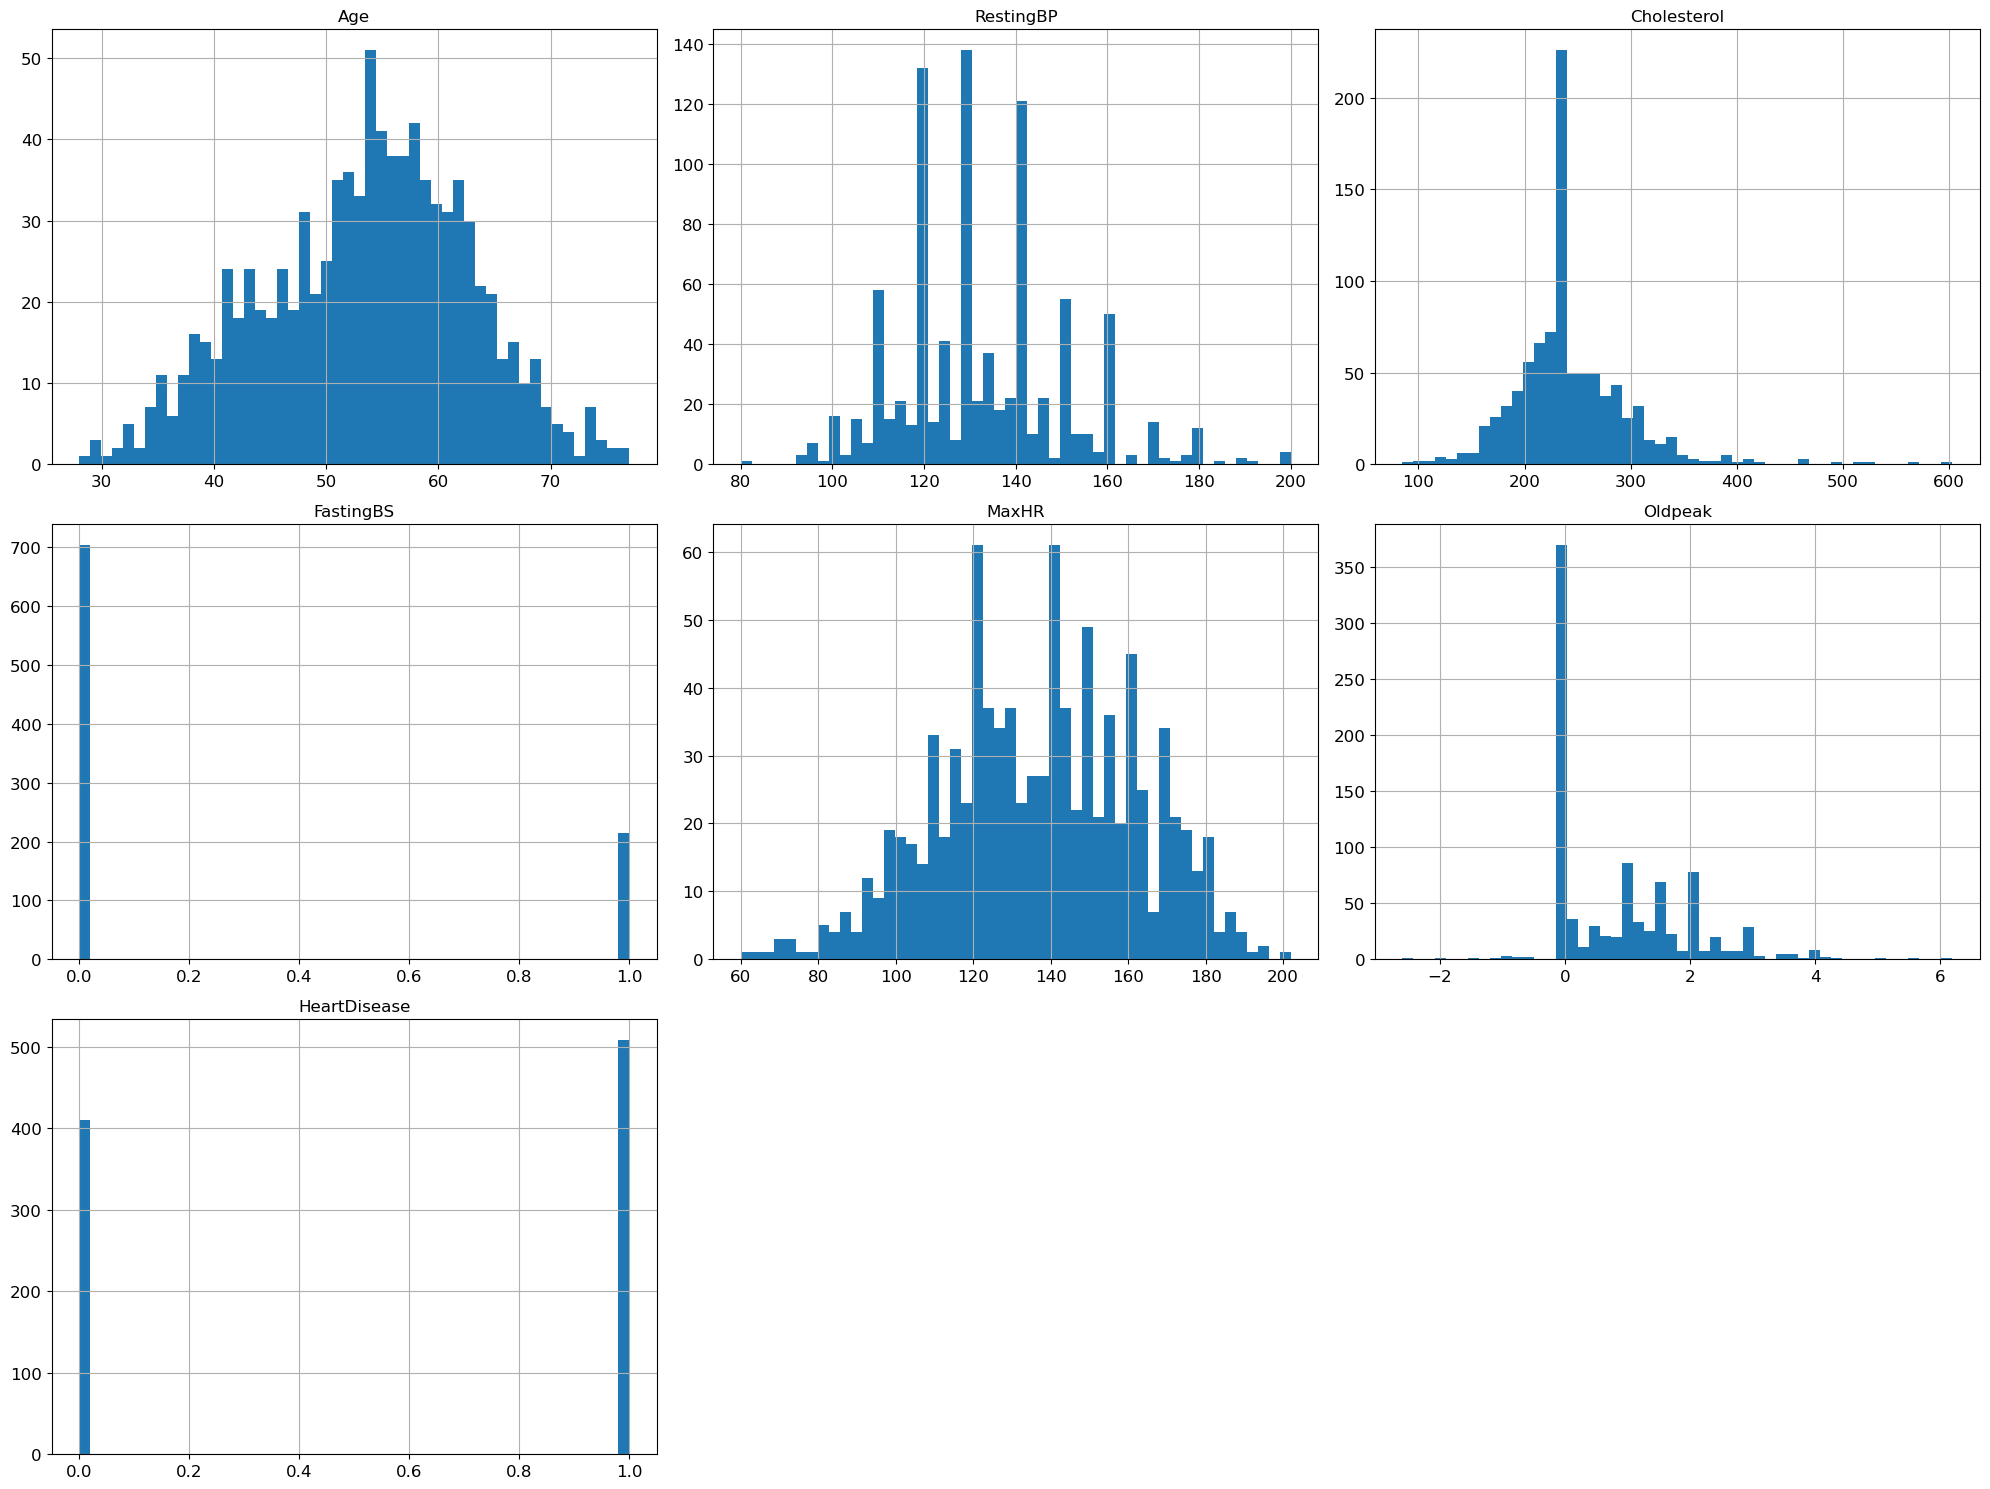

In [13]:
# create histograms for numeric data
heart.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## CountPlots for Categorical Attributes

In [14]:
# create value count plots for categorical data

columns_cat = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']#, 'HeartDisease']

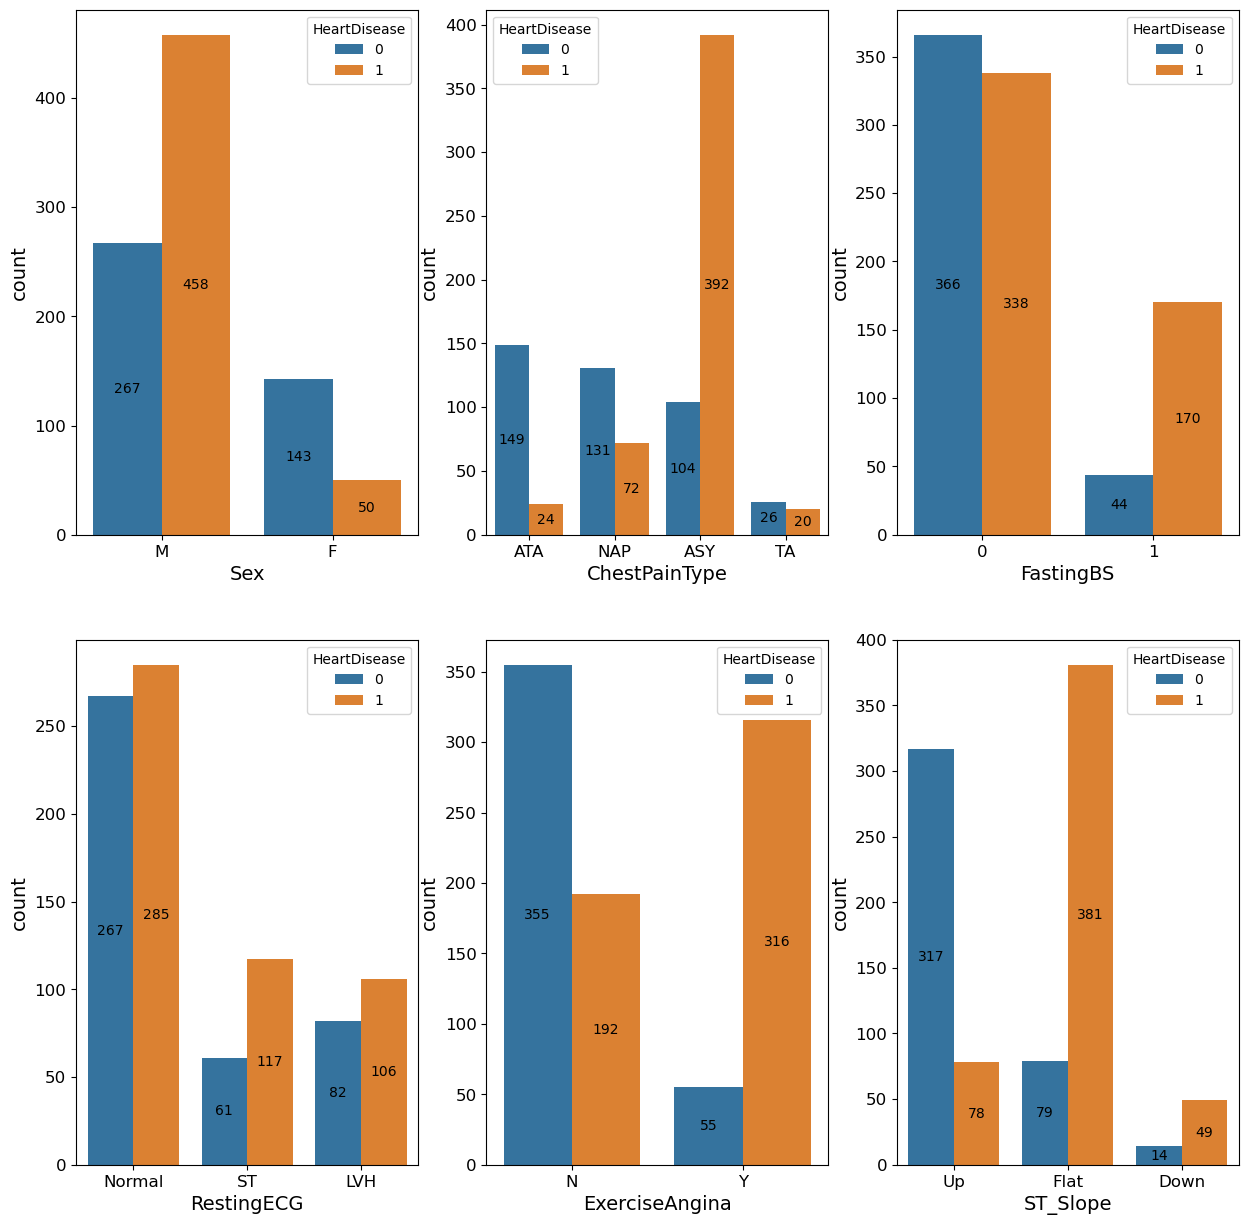

Saving figure categorical_counts


<Figure size 640x480 with 0 Axes>

In [15]:
fig = plt.figure(figsize = (15,15))

for idx, p in enumerate(columns_cat):
    ax = plt.subplot(2,3, idx+1)
    sns.countplot(x=heart[p], hue=heart['HeartDisease'], ax=ax, saturation=0.7)
    for container in ax.containers:
        ax.bar_label(container, label_type='center')
plt.show()

save_fig('categorical_counts')

# Correlations / Associations

## Correlations between Numerical Attributes

In [16]:
# correlations for numeric dat
heart_corr = abs(heart.corr(numeric_only=True))

### Heatmap

Saving figure numeric_only heatmap


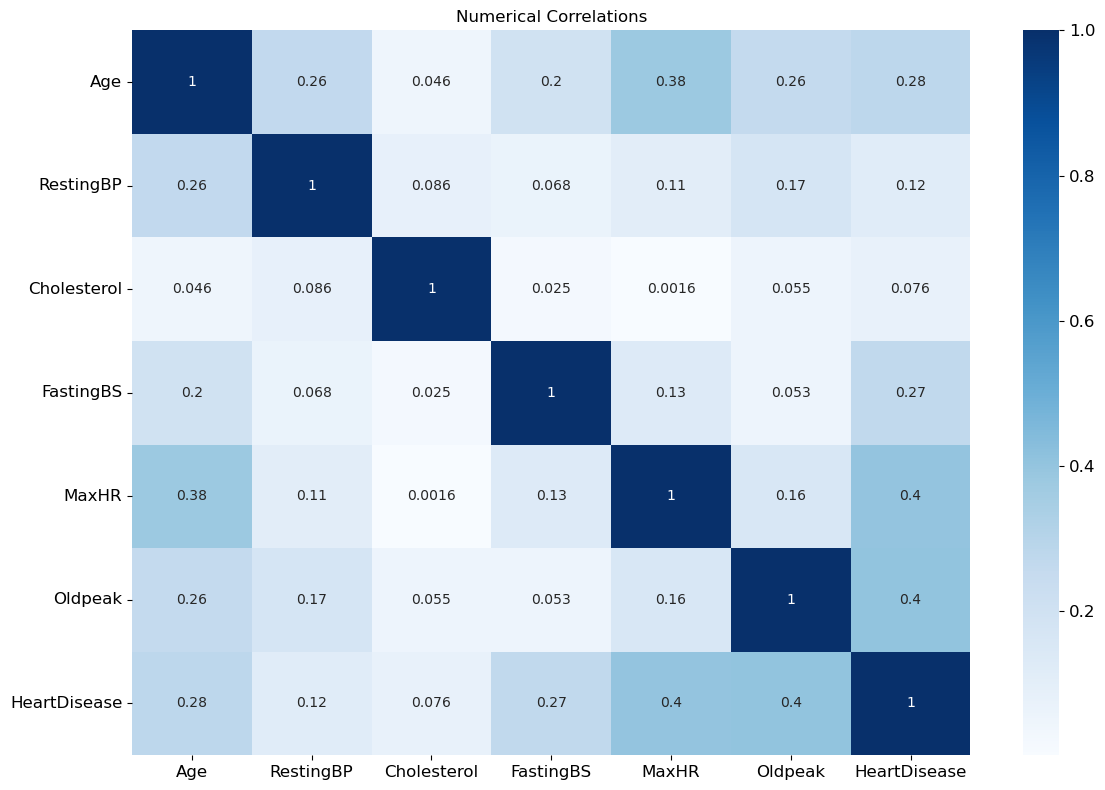

In [17]:
# Create heatmap

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(heart_corr, annot=True, cmap='Blues')
ax.set_title("Numerical Correlations")

save_fig('numeric_only heatmap')

### Heart Disease Correlations
- Not to many attributes are highly correlated to the target variable
- All doesn't seem to be too much colinearity. But lets plot the continous variables against each other

In [18]:
heart_corr_ranked = heart_corr['HeartDisease'].sort_values(ascending=False)[1:]
heart_corr_ranked

Oldpeak        0.403951
MaxHR          0.400421
Age            0.282039
FastingBS      0.267291
RestingBP      0.117798
Cholesterol    0.076114
Name: HeartDisease, dtype: float64

### Scatter Matrix Continous Attributes

Saving figure scatter_matrix_plot


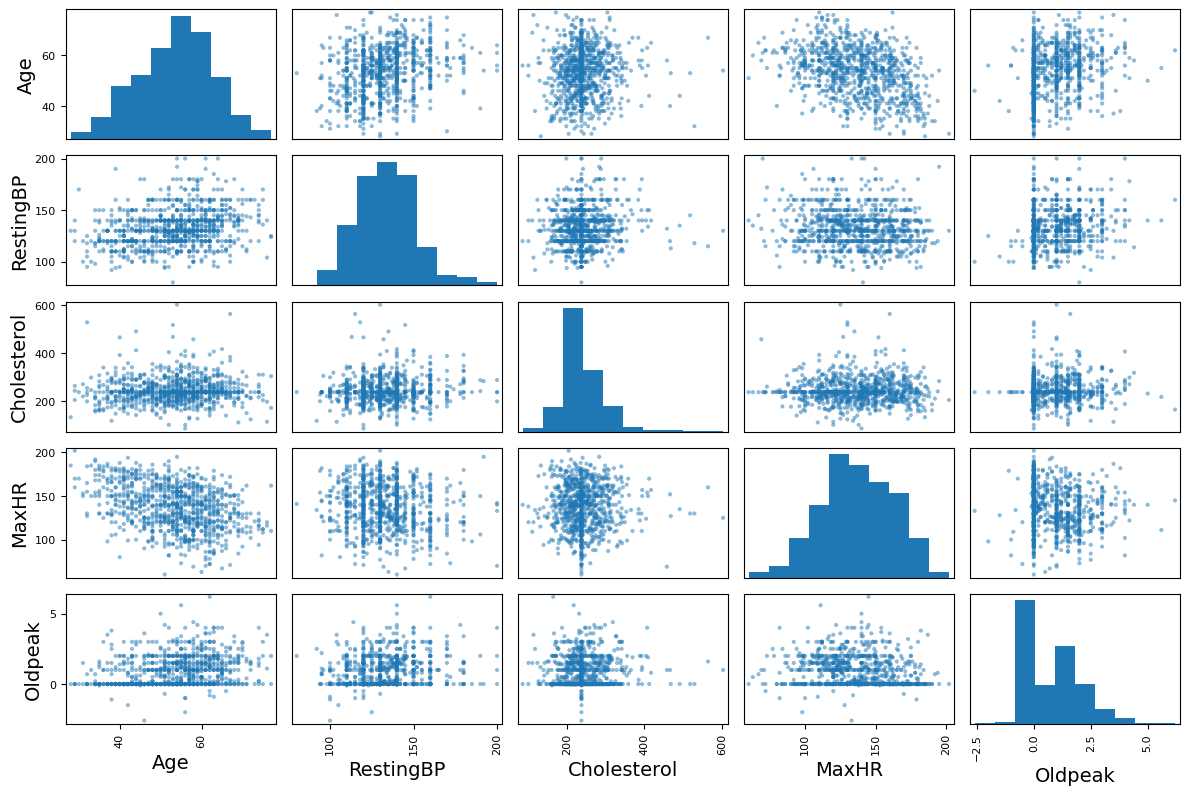

In [19]:
from pandas.plotting import scatter_matrix

attributes_num = ['Age', 'RestingBP', 'Cholesterol','MaxHR', 'Oldpeak']

scatter_matrix(heart[attributes_num], figsize=(12,8))

save_fig("scatter_matrix_plot")

## Association between Categorical Attributes

### Cramers's V

In [20]:
from scipy import stats as ss

In [21]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

### Heatmap

Saving figure association_heatmap


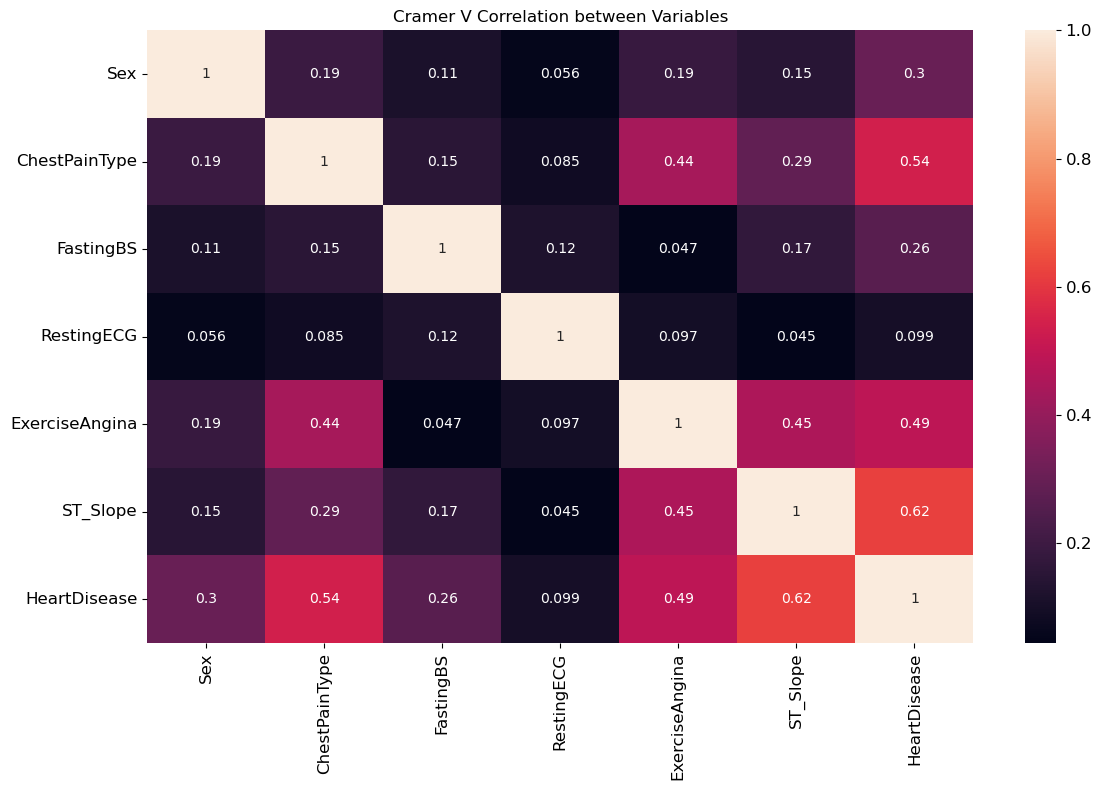

In [22]:
import itertools

cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease'] 

corrM = np.ones((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(heart[col1], heart[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

heart_assoc = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(heart_assoc, annot=True, ax=ax)#, cmap='viridis_r')
ax.set_title("Cramer V Correlation between Variables")

save_fig("association_heatmap")

### Heart Disease Associations
- There is some categorical attributes that have some level of association with Heart Disease, but nothing considered high.
- But there is nothing too associated between attributes
- This will be looked at again following one hot encoding

In [23]:
heart_assoc_ranked = heart_assoc['HeartDisease'].sort_values(ascending=False)[1:]
heart_assoc_ranked


ST_Slope          0.621249
ChestPainType     0.537639
ExerciseAngina    0.491208
Sex               0.301114
FastingBS         0.262775
RestingECG        0.098679
Name: HeartDisease, dtype: float64

# Preparing Data for Machine Learning Algorithms

In [24]:
# create new dr
heart_ohe = heart.copy()

## One Hot Encoding

In [25]:
# create new dr
heart_ohe = heart.copy()

In [26]:
heart_ohe.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [27]:
# create list of categorical columns to pass to ohe_column_transformer function
cat_columns = ['Sex', 'ChestPainType', 'FastingBS','RestingECG', 'ExerciseAngina', 'ST_Slope']

In [28]:
heart_ohe = ohe_columns_transform(cat_columns, heart_ohe)

In [29]:
heart_ohe.head()

,Sex_F,ChestPainType_NAP,ChestPainType_ASY,ChestPainType_TA,FastingBS_1,RestingECG_ST,RestingECG_LVH,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Down,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,140.0,289.0,172.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,49.0,160.0,180.0,156.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,37.0,130.0,283.0,98.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,48.0,138.0,214.0,108.0,1.5,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,150.0,195.0,122.0,0.0,0.0


### Categorical Associations
- Similiar to before one hot encoding
- Still nothing too highly associated 

Saving figure association_heatmap OHE


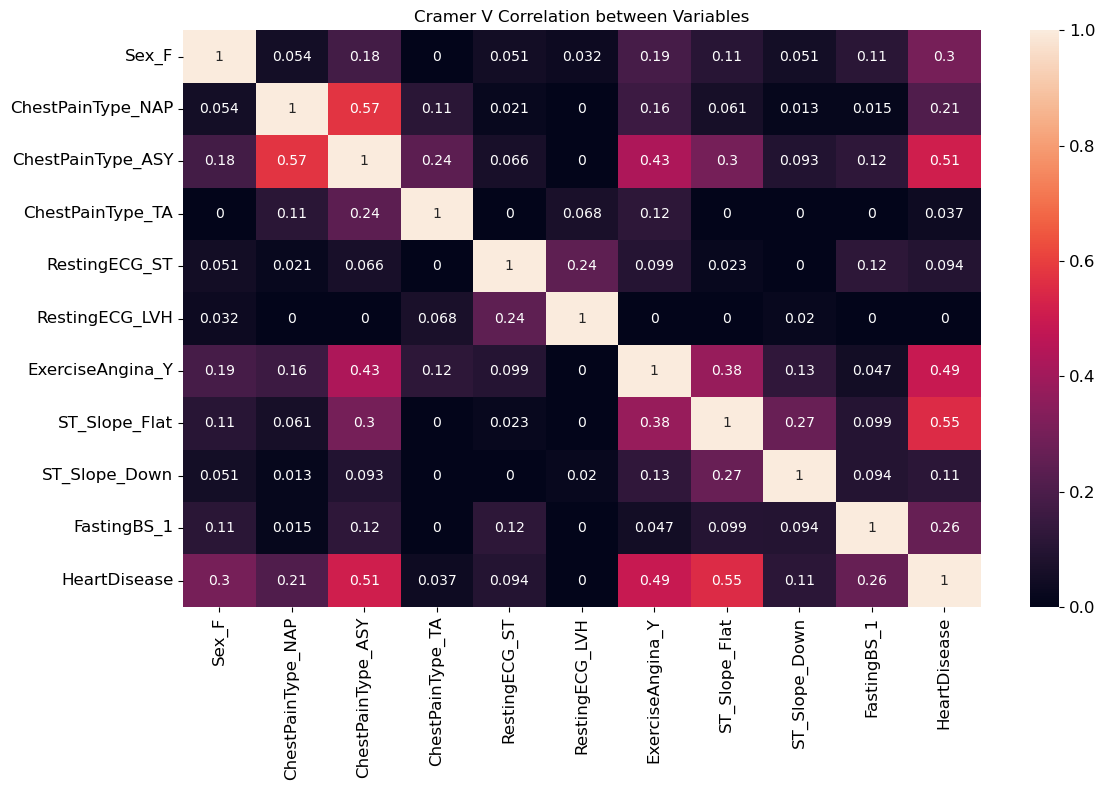

In [30]:
cols = ['Sex_F', 'ChestPainType_NAP', 'ChestPainType_ASY', 'ChestPainType_TA','RestingECG_ST', 'RestingECG_LVH', 'ExerciseAngina_Y', 'ST_Slope_Flat',
       'ST_Slope_Down', 'FastingBS_1', 'HeartDisease' ] 

corrM = np.ones((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(heart_ohe[col1], heart_ohe[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

heart_assoc = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(heart_assoc, annot=True, ax=ax)
ax.set_title("Cramer V Correlation between Variables")

save_fig("association_heatmap OHE")

In [31]:
heart_ohe_assoc_ranked = heart_assoc['HeartDisease'].sort_values(ascending=False)[1:]
heart_ohe_assoc_ranked

ST_Slope_Flat        0.551254
ChestPainType_ASY    0.513737
ExerciseAngina_Y     0.491208
Sex_F                0.301114
FastingBS_1          0.262775
ChestPainType_NAP    0.207828
ST_Slope_Down        0.113548
RestingECG_ST        0.094183
ChestPainType_TA     0.037255
RestingECG_LVH       0.000000
Name: HeartDisease, dtype: float64

## Create Train, Validations, and Test Sets

In [32]:
heart_ohe.head()

,Sex_F,ChestPainType_NAP,ChestPainType_ASY,ChestPainType_TA,FastingBS_1,RestingECG_ST,RestingECG_LVH,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Down,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,140.0,289.0,172.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,49.0,160.0,180.0,156.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,37.0,130.0,283.0,98.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,48.0,138.0,214.0,108.0,1.5,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,150.0,195.0,122.0,0.0,0.0


In [33]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_split_scale(heart_ohe, heart_ohe.columns[-1], 10, -1, StandardScaler())

In [34]:
X_train.head()

,Sex_F,ChestPainType_NAP,ChestPainType_ASY,ChestPainType_TA,FastingBS_1,RestingECG_ST,RestingECG_LVH,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Down,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
364,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.259245,-0.707515,-0.137674,-1.505210,-0.815911
98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.259245,-0.707515,-3.234972,0.147063,-0.815911
600,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.364009,-0.131107,-0.748983,-1.543635,0.113565
201,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.788401,-0.707515,-0.280313,0.531312,-0.815911
345,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.621183,0.157098,-0.137674,-0.237187,-0.815911


# Model Pipeline all Features

In [35]:
# create machine learning model_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [36]:
model_pipeline = []
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(SGDClassifier(random_state=42))
model_pipeline.append(RandomForestClassifier(random_state=42))
model_pipeline.append(GradientBoostingClassifier(random_state=42))
model_pipeline.append(GaussianNB())

## Performance Model Summary All Features

In [37]:
model_list = ['KNN', 'SGD','RandomForest', 'GradientBoosting', 'NaiveBayes']

Saving figure confustion matrix all


,Model,Accuracy,Precision,Recall,AUC
2_all,RandomForest,0.896739,0.915094,0.906542,0.89
3_all,GradientBoosting,0.853261,0.900000,0.841121,0.86
0_all,KNN,0.831522,0.872549,0.831776,0.83
4_all,NaiveBayes,0.831522,0.895833,0.803738,0.84
1_all,SGD,0.771739,0.857143,0.728972,0.78


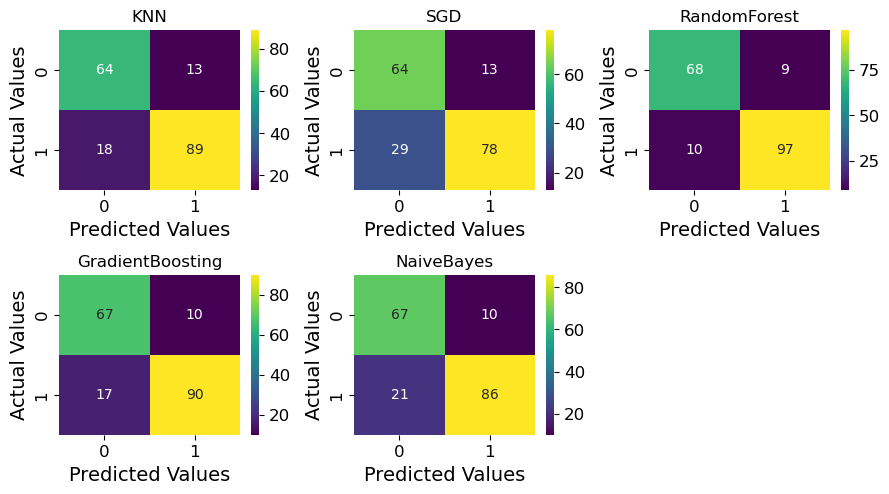

In [38]:
results_all = model_pipeline_classification(model_pipeline, model_list).rename('{}_all'.format)
results_all.sort_values(by='Accuracy', ascending=False)    
    

# Feature Selection
- Run models to get necessary attributes
- Compare feature informtion from the following:
    - Look at top correlations
    - Look at top associations
    - SGDC coefficients
    - RandomForest feature importances
    - GradientBoosting fearute imporantance
- Select Top Features


## StochasticGradientDescent

In [39]:
import more_itertools

In [40]:
sgdc = SGDClassifier(random_state = 42)
sgdc.fit(X_train, y_train)

# since the _coef_ attribute is a list of lists, it needs to be flatten to a list in order to zip
sgdc_coef = list(more_itertools.flatten(sgdc.coef_)) 

sgdc_coef_ranked = sorted(zip(np.absolute(sgdc_coef), X_train.columns), reverse=True)
display(sgdc_coef_ranked)
sgdc_coef_value = list(zip(*sgdc_coef_ranked))[0]
sgdc_coef_feature = list(zip(*sgdc_coef_ranked))[1]


[(4.177763851898228, 'Sex_F'),
 (3.655543370410955, 'ExerciseAngina_Y'),
 (3.6555433704109337, 'ST_Slope_Flat'),
 (2.611102407436402, 'FastingBS_1'),
 (2.3720870747928395, 'RestingBP'),
 (2.088881925949126, 'ST_Slope_Down'),
 (2.0888819259491007, 'ChestPainType_ASY'),
 (1.044440962974562, 'ChestPainType_TA'),
 (0.8142216897150688, 'Oldpeak'),
 (0.6911405604980801, 'Cholesterol'),
 (0.6745922084048805, 'MaxHR'),
 (0.5222204814872686, 'RestingECG_LVH'),
 (0.17527149983148724, 'Age'),
 (4.07757800577974e-15, 'RestingECG_ST'),
 (9.2672227404085e-17, 'ChestPainType_NAP')]

## RandomForest

In [41]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# get feature_importances into a list of tuples 
rfc_feature_importances = sorted(zip(rfc.feature_importances_, X_train.columns), reverse=True)
display(rfc_feature_importances)
rfc_importance_value = list(zip(*rfc_feature_importances))[0]
rfc_importance_name = list(zip(*rfc_feature_importances))[1]  

[(0.172408550382472, 'ST_Slope_Flat'),
 (0.1271302328944486, 'Oldpeak'),
 (0.11648583703472735, 'MaxHR'),
 (0.11045289906179322, 'ExerciseAngina_Y'),
 (0.09389263881498763, 'Cholesterol'),
 (0.0930868046786908, 'Age'),
 (0.08236522278135977, 'ChestPainType_ASY'),
 (0.07537114231462501, 'RestingBP'),
 (0.03869980958157969, 'Sex_F'),
 (0.023902014671802262, 'FastingBS_1'),
 (0.02008006853923174, 'RestingECG_LVH'),
 (0.016008059994250822, 'RestingECG_ST'),
 (0.014016210853322417, 'ChestPainType_NAP'),
 (0.008451600128350513, 'ST_Slope_Down'),
 (0.007648908268358325, 'ChestPainType_TA')]

## GradientBoosting

In [42]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# get feature_importances into a list of tuples 
gbc_feature_importances = sorted(zip(gbc.feature_importances_, X_train.columns), reverse=True)
display(gbc_feature_importances)
gbc_importance_value = list(zip(*gbc_feature_importances))[0]
gbc_importance_name = list(zip(*gbc_feature_importances))[1]  

[(0.3365229381584417, 'ST_Slope_Flat'),
 (0.13279925682405122, 'ExerciseAngina_Y'),
 (0.13150057133876072, 'Oldpeak'),
 (0.10089136927562917, 'ChestPainType_ASY'),
 (0.06876232422354618, 'Cholesterol'),
 (0.06162981168494594, 'MaxHR'),
 (0.054955973481935906, 'Sex_F'),
 (0.04581613956795858, 'Age'),
 (0.03689466103660144, 'RestingBP'),
 (0.012844405185649138, 'FastingBS_1'),
 (0.006516397949875548, 'ChestPainType_NAP'),
 (0.004581783366406826, 'RestingECG_LVH'),
 (0.002625122481586753, 'ChestPainType_TA'),
 (0.002473351151209277, 'RestingECG_ST'),
 (0.0011858942734016707, 'ST_Slope_Down')]

## Naive Bayes Gaussian

In [43]:
nbg = GaussianNB()
nbg.fit(X_train, y_train)

nbg_theta_1 = sorted(zip(abs(nbg.theta_[1]), X_train.columns), reverse=True)
display(nbg_theta_1)
nbg_theta_value = list(zip(*nbg_theta_1))[0]
nbg_theta_feature = list(zip(*nbg_theta_1))[1]

[(0.7593220338983051, 'ST_Slope_Flat'),
 (0.7559322033898305, 'ChestPainType_ASY'),
 (0.6271186440677966, 'ExerciseAngina_Y'),
 (0.3873664859843802, 'Oldpeak'),
 (0.373171886654587, 'MaxHR'),
 (0.3016949152542373, 'FastingBS_1'),
 (0.2620856143916055, 'Age'),
 (0.20677966101694914, 'RestingECG_ST'),
 (0.2033898305084746, 'RestingECG_LVH'),
 (0.14915254237288136, 'ChestPainType_NAP'),
 (0.1309149208120131, 'RestingBP'),
 (0.10508474576271186, 'Sex_F'),
 (0.08135593220338982, 'ST_Slope_Down'),
 (0.0474453505935679, 'Cholesterol'),
 (0.04067796610169491, 'ChestPainType_TA')]

## Top Features 

### Create df for Correlations and Associations

In [44]:
corr_assoc = pd.DataFrame({'correlations': heart_corr_ranked.index, 'corr_value':heart_corr_ranked.tolist(), 
                            'associations': heart_assoc_ranked.index, 'assoc_value':heart_assoc_ranked.tolist()})

In [45]:
ohe_assoc = pd.DataFrame({'associations': heart_ohe_assoc_ranked.index, 'assoc_value':heart_ohe_assoc_ranked.tolist()})

### Create df for Features Importance, Coefficients and theta

In [46]:
heart_features = pd.DataFrame({'sgdc_coef_feature':sgdc_coef_feature, 'sgdc_coef_value':sgdc_coef_value,
                               'gbc_importance_feature': gbc_importance_name, 'gbc_importance_value': gbc_importance_value,
                               'rfc_importance_feature': rfc_importance_name, 'rfc_importance_value': rfc_importance_value,
                               'nbg_theta_feature': nbg_theta_feature, 'nbg_theta_value':nbg_theta_value})

In [47]:
heart_features

,sgdc_coef_feature,sgdc_coef_value,gbc_importance_feature,gbc_importance_value,rfc_importance_feature,rfc_importance_value,nbg_theta_feature,nbg_theta_value
0,Sex_F,4.177764e+00,ST_Slope_Flat,0.336523,ST_Slope_Flat,0.172409,ST_Slope_Flat,0.759322
1,ExerciseAngina_Y,3.655543e+00,ExerciseAngina_Y,0.132799,Oldpeak,0.127130,ChestPainType_ASY,0.755932
2,ST_Slope_Flat,3.655543e+00,Oldpeak,0.131501,MaxHR,0.116486,ExerciseAngina_Y,0.627119
3,FastingBS_1,2.611102e+00,ChestPainType_ASY,0.100891,ExerciseAngina_Y,0.110453,Oldpeak,0.387366
4,RestingBP,2.372087e+00,Cholesterol,0.068762,Cholesterol,0.093893,MaxHR,0.373172
5,ST_Slope_Down,2.088882e+00,MaxHR,0.061630,Age,0.093087,FastingBS_1,0.301695
6,ChestPainType_ASY,2.088882e+00,Sex_F,0.054956,ChestPainType_ASY,0.082365,Age,0.262086
7,ChestPainType_TA,1.044441e+00,Age,0.045816,RestingBP,0.075371,RestingECG_ST,0.206780
8,Oldpeak,8.142217e-01,RestingBP,0.036895,Sex_F,0.038700,RestingECG_LVH,0.203390
9,Cholesterol,6.911406e-01,FastingBS_1,0.012844,FastingBS_1,0.023902,ChestPainType_NAP,0.149153


In [48]:
corr_assoc

,correlations,corr_value,associations,assoc_value
0,Oldpeak,0.403951,ST_Slope,0.621249
1,MaxHR,0.400421,ChestPainType,0.537639
2,Age,0.282039,ExerciseAngina,0.491208
3,FastingBS,0.267291,Sex,0.301114
4,RestingBP,0.117798,FastingBS,0.262775
5,Cholesterol,0.076114,RestingECG,0.098679


In [49]:
ohe_assoc

,associations,assoc_value
0,ST_Slope_Flat,0.551254
1,ChestPainType_ASY,0.513737
2,ExerciseAngina_Y,0.491208
3,Sex_F,0.301114
4,FastingBS_1,0.262775
5,ChestPainType_NAP,0.207828
6,ST_Slope_Down,0.113548
7,RestingECG_ST,0.094183
8,ChestPainType_TA,0.037255
9,RestingECG_LVH,0.000000


### Select Appropraite Range and combine dfs

In [50]:
features_top = pd.concat([heart_features[:10], corr_assoc[['correlations','corr_value']][:5], ohe_assoc[:5]], axis=1)
features_top

,sgdc_coef_feature,sgdc_coef_value,gbc_importance_feature,gbc_importance_value,rfc_importance_feature,rfc_importance_value,nbg_theta_feature,nbg_theta_value,correlations,corr_value,associations,assoc_value
0,Sex_F,4.177764,ST_Slope_Flat,0.336523,ST_Slope_Flat,0.172409,ST_Slope_Flat,0.759322,Oldpeak,0.403951,ST_Slope_Flat,0.551254
1,ExerciseAngina_Y,3.655543,ExerciseAngina_Y,0.132799,Oldpeak,0.127130,ChestPainType_ASY,0.755932,MaxHR,0.400421,ChestPainType_ASY,0.513737
2,ST_Slope_Flat,3.655543,Oldpeak,0.131501,MaxHR,0.116486,ExerciseAngina_Y,0.627119,Age,0.282039,ExerciseAngina_Y,0.491208
3,FastingBS_1,2.611102,ChestPainType_ASY,0.100891,ExerciseAngina_Y,0.110453,Oldpeak,0.387366,FastingBS,0.267291,Sex_F,0.301114
4,RestingBP,2.372087,Cholesterol,0.068762,Cholesterol,0.093893,MaxHR,0.373172,RestingBP,0.117798,FastingBS_1,0.262775
5,ST_Slope_Down,2.088882,MaxHR,0.061630,Age,0.093087,FastingBS_1,0.301695,NaN,NaN,NaN,NaN
6,ChestPainType_ASY,2.088882,Sex_F,0.054956,ChestPainType_ASY,0.082365,Age,0.262086,NaN,NaN,NaN,NaN
7,ChestPainType_TA,1.044441,Age,0.045816,RestingBP,0.075371,RestingECG_ST,0.206780,NaN,NaN,NaN,NaN
8,Oldpeak,0.814222,RestingBP,0.036895,Sex_F,0.038700,RestingECG_LVH,0.203390,NaN,NaN,NaN,NaN
9,Cholesterol,0.691141,FastingBS_1,0.012844,FastingBS_1,0.023902,ChestPainType_NAP,0.149153,NaN,NaN,NaN,NaN


### Value Counts to determine top features

In [51]:
# combining the labels of the features_top into a single array of arrays
features_count = np.vstack((features_top['sgdc_coef_feature'], features_top['gbc_importance_feature'], features_top['rfc_importance_feature'],
                           features_top['nbg_theta_feature'], features_top['correlations'], features_top['associations']))#, features_top['associations']))
# converting array of arrays into flat list
feat_count = feat_count = list(more_itertools.flatten(features_count))
# new df and count values
features_count_df = pd.DataFrame({'counts':feat_count})
features_count_df.value_counts()

counts           
ChestPainType_ASY    5
ExerciseAngina_Y     5
FastingBS_1          5
Oldpeak              5
ST_Slope_Flat        5
Age                  4
MaxHR                4
RestingBP            4
Sex_F                4
Cholesterol          3
ChestPainType_NAP    1
ChestPainType_TA     1
FastingBS            1
RestingECG_LVH       1
RestingECG_ST        1
ST_Slope_Down        1
dtype: int64

## Top Feature Selection
- Value counts of 3 or greater

In [52]:
top_features = features_count_df.value_counts()[0:10].reset_index()#drop=True)
top_features = top_features['counts'].tolist()
top_features 

['ChestPainType_ASY',
 'ExerciseAngina_Y',
 'FastingBS_1',
 'Oldpeak',
 'ST_Slope_Flat',
 'Age',
 'MaxHR',
 'RestingBP',
 'Sex_F',
 'Cholesterol']

# Model Pipeline with Top 10 Features

## Performance Model Summary Top 10 Features

Saving figure confustion matrix top


,Model,Accuracy,Precision,Recall,AUC
3_top10,GradientBoosting,0.864130,0.901961,0.859813,0.86
2_top10,RandomForest,0.858696,0.885714,0.869159,0.86
4_top10,NaiveBayes,0.826087,0.878788,0.813084,0.83
0_top10,KNN,0.804348,0.865979,0.785047,0.81
1_top10,SGD,0.793478,0.905882,0.719626,0.81


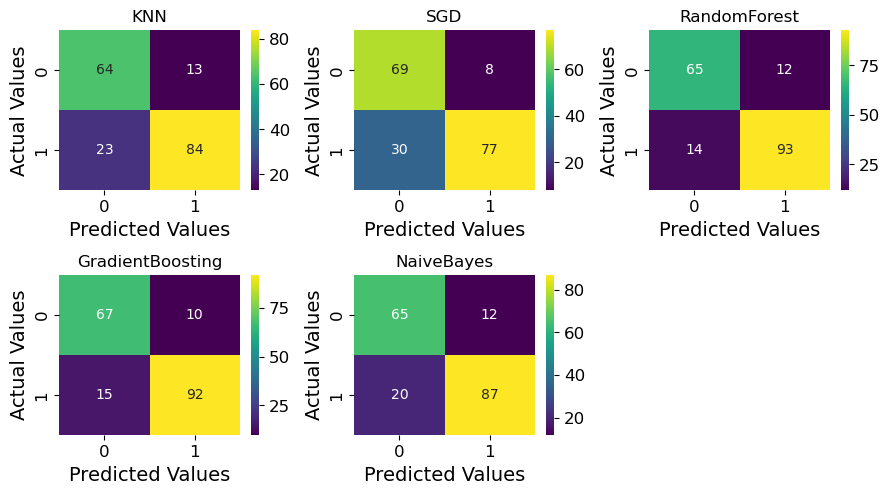

In [53]:
results_top10 = model_pipeline_classification_top(model_pipeline, model_list).rename('{}_top10'.format)
results_top10.sort_values(by='Accuracy', ascending=False)

# Model Pipline with 5 Top Features
- value counts of 5

In [54]:
features_count_df.value_counts()

counts           
ChestPainType_ASY    5
ExerciseAngina_Y     5
FastingBS_1          5
Oldpeak              5
ST_Slope_Flat        5
Age                  4
MaxHR                4
RestingBP            4
Sex_F                4
Cholesterol          3
ChestPainType_NAP    1
ChestPainType_TA     1
FastingBS            1
RestingECG_LVH       1
RestingECG_ST        1
ST_Slope_Down        1
dtype: int64

## Perfmance Model Summary Top 5 Features

In [55]:
top_features = features_count_df.value_counts()[0:5].reset_index()
top_features = top_features['counts'].tolist()
top_features

['ChestPainType_ASY',
 'ExerciseAngina_Y',
 'FastingBS_1',
 'Oldpeak',
 'ST_Slope_Flat']

Saving figure confustion matrix top


,Model,Accuracy,Precision,Recall,AUC
0_top5,KNN,0.853261,0.892157,0.850467,0.85
4_top5,NaiveBayes,0.853261,0.892157,0.850467,0.85
3_top5,GradientBoosting,0.847826,0.898990,0.831776,0.85
1_top5,SGD,0.826087,0.857143,0.841121,0.82
2_top5,RandomForest,0.826087,0.886598,0.803738,0.83


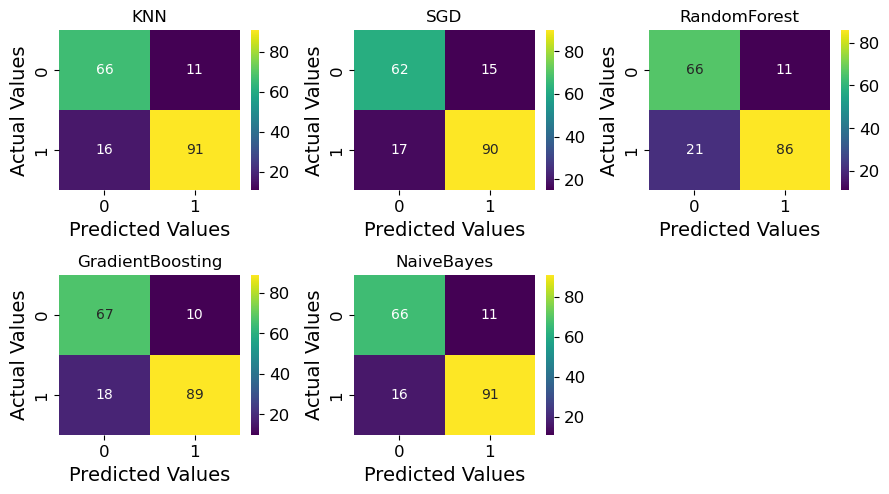

In [56]:
results_top5 = model_pipeline_classification_top(model_pipeline, model_list).rename('{}_top5'.format)
results_top5.sort_values(by='Accuracy', ascending=False)

# Model Pipeline with Top 9 Features  
- Selecting value counts of 4 and 5

In [57]:
features_count_df.value_counts()

counts           
ChestPainType_ASY    5
ExerciseAngina_Y     5
FastingBS_1          5
Oldpeak              5
ST_Slope_Flat        5
Age                  4
MaxHR                4
RestingBP            4
Sex_F                4
Cholesterol          3
ChestPainType_NAP    1
ChestPainType_TA     1
FastingBS            1
RestingECG_LVH       1
RestingECG_ST        1
ST_Slope_Down        1
dtype: int64

In [58]:
top_features = features_count_df.value_counts()[0:9].reset_index()
top_features = top_features['counts'].tolist()
top_features

['ChestPainType_ASY',
 'ExerciseAngina_Y',
 'FastingBS_1',
 'Oldpeak',
 'ST_Slope_Flat',
 'Age',
 'MaxHR',
 'RestingBP',
 'Sex_F']

## Perfomance Model Summary Top 9 Features

Saving figure confustion matrix top


,Model,Accuracy,Precision,Recall,AUC
2_top9,RandomForest,0.853261,0.892157,0.850467,0.85
3_top9,GradientBoosting,0.842391,0.882353,0.841121,0.84
4_top9,NaiveBayes,0.826087,0.878788,0.813084,0.83
1_top9,SGD,0.820652,0.920455,0.757009,0.83
0_top9,KNN,0.804348,0.881720,0.766355,0.81


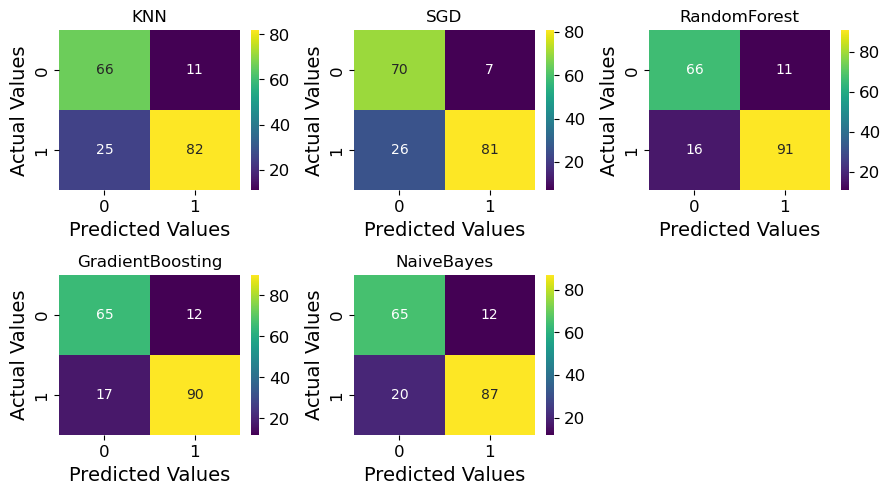

In [59]:
results_top9 = model_pipeline_classification_top(model_pipeline, model_list).rename('{}_top9'.format)
results_top9.sort_values(by='Accuracy', ascending=False)

# Model Performance Summary 1
- The top 2 models were the RandomForest(all features) with 89.67% accuracy and the GradientBoosting (top10) with 86.41%  
- The range in accuracy for the top 7 was 89.67 to 85.32 
- Lets look further into any multi-colinearity issues by measuring VIF and see why the SGD models are performing so poorly.

In [60]:
results_summary1 = pd.concat([results_all, results_top10, results_top9, results_top5])
results_summary1.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,AUC
2_all,RandomForest,0.896739,0.915094,0.906542,0.89
3_top10,GradientBoosting,0.864130,0.901961,0.859813,0.86
2_top10,RandomForest,0.858696,0.885714,0.869159,0.86
4_top5,NaiveBayes,0.853261,0.892157,0.850467,0.85
2_top9,RandomForest,0.853261,0.892157,0.850467,0.85
3_all,GradientBoosting,0.853261,0.900000,0.841121,0.86
0_top5,KNN,0.853261,0.892157,0.850467,0.85
3_top5,GradientBoosting,0.847826,0.898990,0.831776,0.85
3_top9,GradientBoosting,0.842391,0.882353,0.841121,0.84
0_all,KNN,0.831522,0.872549,0.831776,0.83


# MultiCollinearity

In [61]:
from sklearn.linear_model import LinearRegression

def calculate_vif(df, features):    
    vif, tolerance = {}, {}    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [62]:
features = heart_ohe.columns[:-1]
features

Index(['Sex_F', 'ChestPainType_NAP', 'ChestPainType_ASY', 'ChestPainType_TA',
       'FastingBS_1', 'RestingECG_ST', 'RestingECG_LVH', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Down', 'Age', 'RestingBP', 'Cholesterol',
       'MaxHR', 'Oldpeak'],
      dtype='object')

## VIF with all Features

In [63]:
calculate_vif(heart_ohe,features).sort_values(by='VIF', ascending=False)

,VIF,Tolerance
ChestPainType_ASY,2.424037,0.412535
ChestPainType_NAP,1.802187,0.554881
ST_Slope_Flat,1.659910,0.602442
ExerciseAngina_Y,1.579381,0.633160
MaxHR,1.524867,0.655795
Oldpeak,1.522448,0.656837
ST_Slope_Down,1.433489,0.697599
Age,1.399796,0.714390
ChestPainType_TA,1.279478,0.781569
RestingECG_LVH,1.164407,0.858806


Really nothing there just confirms the correlations and associations results. So, lets run the SGD model using the different subsets the coefficents values obtained from the model with all features

In [64]:
display(sgdc_coef_ranked)
top_features = list(sgdc_coef_feature[0:9])
top_features

[(4.177763851898228, 'Sex_F'),
 (3.655543370410955, 'ExerciseAngina_Y'),
 (3.6555433704109337, 'ST_Slope_Flat'),
 (2.611102407436402, 'FastingBS_1'),
 (2.3720870747928395, 'RestingBP'),
 (2.088881925949126, 'ST_Slope_Down'),
 (2.0888819259491007, 'ChestPainType_ASY'),
 (1.044440962974562, 'ChestPainType_TA'),
 (0.8142216897150688, 'Oldpeak'),
 (0.6911405604980801, 'Cholesterol'),
 (0.6745922084048805, 'MaxHR'),
 (0.5222204814872686, 'RestingECG_LVH'),
 (0.17527149983148724, 'Age'),
 (4.07757800577974e-15, 'RestingECG_ST'),
 (9.2672227404085e-17, 'ChestPainType_NAP')]

['Sex_F',
 'ExerciseAngina_Y',
 'ST_Slope_Flat',
 'FastingBS_1',
 'RestingBP',
 'ST_Slope_Down',
 'ChestPainType_ASY',
 'ChestPainType_TA',
 'Oldpeak']

## SGDC Model with best Performance
- All features  minus directly related features with lower coefficient values

In [65]:
sgdc = SGDClassifier(random_state = 42)
sgdc.fit(X_train[top_features], y_train)

preds_sgdc = sgdc.predict(X_val[top_features])

acc_score_sgdc = accuracy_score(y_val, preds_sgdc)
prec_score_sgdc = precision_score(y_val, preds_sgdc)
recall_score_sgdc = recall_score(y_val, preds_sgdc)
auc_score_sgdc = roc_auc_score(y_val, preds_sgdc)

print('Accuracy =',  acc_score_sgdc)
print('Precision =', prec_score_sgdc)
print('Recall =', recall_score_sgdc)
print('AUC =', auc_score_sgdc)

Accuracy = 0.8641304347826086
Precision = 0.8660714285714286
Recall = 0.9065420560747663
AUC = 0.8558684306347858


### VIF for SGDC Best Model Features

In [66]:
calculate_vif(heart_ohe,top_features).sort_values(by='VIF', ascending=False)

,VIF,Tolerance
ST_Slope_Flat,1.535028,0.651454
ExerciseAngina_Y,1.526047,0.655288
Oldpeak,1.478710,0.676265
ST_Slope_Down,1.403170,0.712672
ChestPainType_ASY,1.394429,0.717140
ChestPainType_TA,1.097303,0.911325
Sex_F,1.066245,0.937870
FastingBS_1,1.058173,0.945025
RestingBP,1.055375,0.947531


## SGDC Conclustion
- After interating through various combinations of features, the model that performed the best is:
    - All Features minus directly related attributes with the lower coefficeint value
        - 'Sex_F', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'FastingBS_1', 'RestingBP', 'ST_Slope_Down',
        - 'ChestPainType_ASY', 'ChestPainType_TA', 'Oldpeak'
    - This combination also reduced the VIF values from a range of (2.42 to 1.05) to (1.55 to 1.06)

# Model Pipeline with SGDC Top Features

## Performance Model Summary for Top SGDC Features

Saving figure confustion matrix top


,Model,Accuracy,Precision,Recall,AUC
1_sgdc,SGD,0.864130,0.866071,0.906542,0.86
4_sgdc,NaiveBayes,0.853261,0.908163,0.831776,0.86
3_sgdc,GradientBoosting,0.847826,0.876190,0.859813,0.85
0_sgdc,KNN,0.842391,0.897959,0.822430,0.85
2_sgdc,RandomForest,0.831522,0.865385,0.841121,0.83


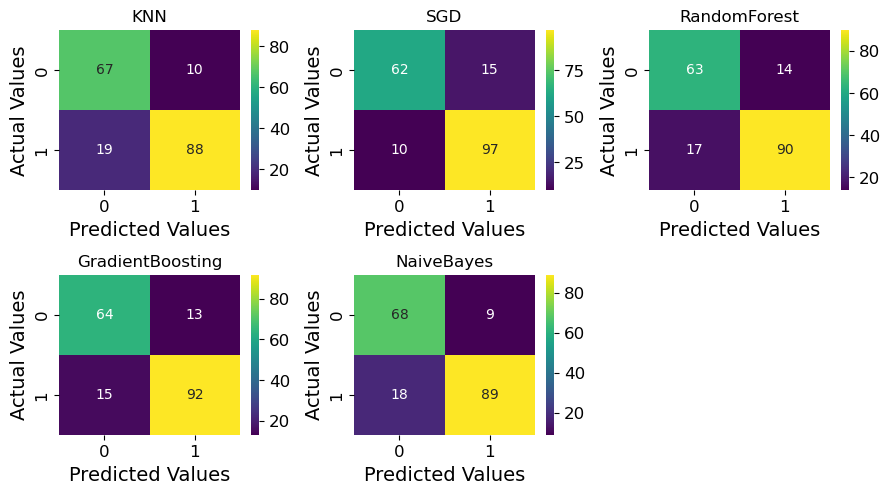

In [67]:
results_sgdc = model_pipeline_classification_top(model_pipeline, model_list).rename('{}_sgdc'.format)
results_sgdc.sort_values(by='Accuracy', ascending=False)

# Model Performance Summary 2
- After reducing the multi-colinearity during the SGDC optimization the top models are:
    - RandomForest with all features, SGD with top SGDC features, and GradientBoosting with top 10 features
        - Acurracy scores (respectively): 89.97, 86.41, 86.41
- Lets perform a gridsearch on the RandomForest all and GradientBoosting top10

In [68]:
results_summary2 = pd.concat([results_all, results_top10, results_top9, results_top5, results_sgdc])
results_summary2.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,AUC
2_all,RandomForest,0.896739,0.915094,0.906542,0.89
1_sgdc,SGD,0.864130,0.866071,0.906542,0.86
3_top10,GradientBoosting,0.864130,0.901961,0.859813,0.86
2_top10,RandomForest,0.858696,0.885714,0.869159,0.86
2_top9,RandomForest,0.853261,0.892157,0.850467,0.85
4_top5,NaiveBayes,0.853261,0.892157,0.850467,0.85
0_top5,KNN,0.853261,0.892157,0.850467,0.85
4_sgdc,NaiveBayes,0.853261,0.908163,0.831776,0.86
3_all,GradientBoosting,0.853261,0.900000,0.841121,0.86
3_sgdc,GradientBoosting,0.847826,0.876190,0.859813,0.85


# Grid Search for Top RandomForest and GradientBoosting

## RandomForest with All Features

In [69]:
from sklearn.model_selection import GridSearchCV 

In [70]:
# -----
# Coarse-Grained RandomForestRegressor GridSearch
# -----

param_grid = {'max_depth': [None, 2, 6, 10],
             'n_estimators': [10, 100, 200, 300, 400, 500],
              'min_samples_split': [10, 12, 16, 20]
             }

grid_search_cv_rfc = GridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid, verbose=1, cv=3)
grid_search_cv_rfc.fit(X_train, y_train)
print('The best parameters are: ', grid_search_cv_rfc.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
The best parameters are:  {'max_depth': 6, 'min_samples_split': 16, 'n_estimators': 300}


In [71]:
# -----
# Coarse-Grained RandomForestRegressor GridSearch
# -----

param_grid = {'max_depth': [4, 5, 6, 7, 8],
             'n_estimators': [250, 275, 300, 325, 350],
              'min_samples_split': [14, 15, 16, 17, 18]
             }

grid_search_cv_rfc = GridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid, verbose=1, cv=3)
grid_search_cv_rfc.fit(X_train, y_train)
print('The best parameters are: ', grid_search_cv_rfc.best_params_)

Fitting 3 folds for each of 125 candidates, totalling 375 fits
The best parameters are:  {'max_depth': 6, 'min_samples_split': 16, 'n_estimators': 300}


In [72]:
# -----
# Medium-Grained RandomForestRegressor GridSearch
# -----

param_grid = {'max_depth': [5, 6, 7],
             'n_estimators': [285, 290, 295, 300, 305, 310, 315],
              'min_samples_split': [15, 16, 17]
             }

grid_search_cv_rfc = GridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid, verbose=1, cv=3)
grid_search_cv_rfc.fit(X_train, y_train)
print('The best parameters are: ', grid_search_cv_rfc.best_params_)

Fitting 3 folds for each of 63 candidates, totalling 189 fits
The best parameters are:  {'max_depth': 6, 'min_samples_split': 16, 'n_estimators': 290}


In [73]:
# -----
# Fine-Grained RandomForestRegressor GridSearch
# -----

param_grid = {'max_depth': [6],
             'n_estimators': [288, 289, 290, 291, 292],
              'min_samples_split': [16]
             }

grid_search_cv_rfc = GridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid, verbose=1, cv=3)
grid_search_cv_rfc.fit(X_train, y_train)
print('The best parameters are: ', grid_search_cv_rfc.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
The best parameters are:  {'max_depth': 6, 'min_samples_split': 16, 'n_estimators': 290}


In [74]:
#from sklearn.metrics import roc_auc_score

In [75]:
# Now lets predict on val set

# save best_params explicitly to avoid redoing gridsearch
# best_params_rfc = {'max_depth': 6, 'min_samples_split': 16, 'n_estimators': 290}

rfc_best = RandomForestClassifier(**grid_search_cv_rfc.best_params_, random_state=42)
rfc_best.fit(X_train, y_train)

preds_rfc = rfc_best.predict(X_val)

acc_score_rfc = accuracy_score(y_val, preds_rfc)
prec_score_rfc = precision_score(y_val, preds_rfc)
recall_score_rfc = recall_score(y_val, preds_rfc)
auc_score_rfc = roc_auc_score(y_val, preds_rfc)

print('Accuracy =',  acc_score_rfc)
print('Precision =', prec_score_rfc)
print('Recall =', recall_score_rfc)
print('AUC =', auc_score_rfc)

Accuracy = 0.875
Precision = 0.9038461538461539
Recall = 0.8785046728971962
AUC = 0.8743172715135331


## GradientBoosting Top 10 Features

In [76]:
# need to re-run code for top features to get top 10
top_features = features_count_df.value_counts()[0:10].reset_index()
top_features = top_features['counts'].tolist()
top_features

['ChestPainType_ASY',
 'ExerciseAngina_Y',
 'FastingBS_1',
 'Oldpeak',
 'ST_Slope_Flat',
 'Age',
 'MaxHR',
 'RestingBP',
 'Sex_F',
 'Cholesterol']

In [77]:
# -----
# Coarse-Grained GradientBoostingClassifier GridSearch
# -----

param_grid = {'max_depth': [None, 2, 6, 10 ,16, 20 , 26],
             'n_estimators': [50, 100, 150, 200, 300],
              'learning_rate': [0.05, 0.2, 0.5, 0.8, 1]
             }

grid_search_cv_gbc = GridSearchCV(GradientBoostingClassifier(random_state=42),
                             param_grid, verbose=1, cv=3)

grid_search_cv_gbc.fit(X_train[top_features], y_train)
print('The best parameters are: ', grid_search_cv_gbc.best_params_)

Fitting 3 folds for each of 175 candidates, totalling 525 fits
The best parameters are:  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}


In [78]:
# -----
# Medium-Grained GradientBoostingClassifier GridSearch
# -----

param_grid = {'max_depth': [1, 2, 3],
             'n_estimators': [130, 140, 150, 160, 170],
              'learning_rate': [0.03, 0.04, 0.05, 0.06, .07]
             }

grid_search_cv_gbc = GridSearchCV(GradientBoostingClassifier(random_state=42),
                             param_grid, verbose=1, cv=3)

grid_search_cv_gbc.fit(X_train[top_features], y_train)
print('The best parameters are: ', grid_search_cv_gbc.best_params_)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
The best parameters are:  {'learning_rate': 0.06, 'max_depth': 1, 'n_estimators': 160}


In [79]:
# -----
# Fine-Grained GradientBoostingClassifier GridSearch
# -----

param_grid = {'max_depth': [1, 2],
             'n_estimators': [157, 158, 159, 160, 161, 162],
              'learning_rate': [0.05, 0.06, 0.07]
             }

grid_search_cv_gbc = GridSearchCV(GradientBoostingClassifier(random_state=42),
                             param_grid, verbose=1, cv=3)
grid_search_cv_gbc.fit(X_train[top_features], y_train)
print('The best parameters are: ', grid_search_cv_gbc.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
The best parameters are:  {'learning_rate': 0.06, 'max_depth': 1, 'n_estimators': 158}


In [80]:
# save best_params explicitly to avoid redoing gridsearch
# best_params_gbc = {'learning_rate': 0.06, 'max_depth': 1, 'n_estimators': 158}

gbc_best = GradientBoostingClassifier(**grid_search_cv_gbc.best_params_, random_state=42)

gbc_best.fit(X_train[top_features], y_train)

preds_gbc = gbc_best.predict(X_val[top_features])

acc_score_gbc = accuracy_score(y_val, preds_gbc)
prec_score_gbc = precision_score(y_val, preds_gbc)
recall_score_gbc = recall_score(y_val, preds_gbc)
auc_score_gbc = roc_auc_score(y_val, preds_gbc)

print('Accuracy =',  acc_score_gbc *100)
print('Precision =', prec_score_gbc *100)
print('Recall =', recall_score_gbc *100)
print('AUC =', auc_score_gbc)

Accuracy = 86.95652173913044
Precision = 91.0891089108911
Recall = 85.98130841121495
AUC = 0.8714649836145163


## GridSearch Results Summary

In [81]:
gridsearch = pd.DataFrame({'Model': ['RandomForest', 'GradientBoosting'], 'Accuracy':[acc_score_rfc, acc_score_gbc],
                               'Precision': [prec_score_rfc, prec_score_gbc], 'Recall': [recall_score_rfc, recall_score_gbc],
                               'AUC': [auc_score_rfc, auc_score_gbc]})
results_gs = gridsearch.rename('{}_gs'.format)
results_gs
                            

,Model,Accuracy,Precision,Recall,AUC
0_gs,RandomForest,0.875000,0.903846,0.878505,0.874317
1_gs,GradientBoosting,0.869565,0.910891,0.859813,0.871465


# Final Model Summary and Selection
- Top model is still the RandomForest with the selected all features with a 89.67% accuracy
- The other top models the RandomForest Classifier with the all features/grid search and the GradientBoosting Classifier with the top 10 features/ grid search
- Final evaluation with be performed the RandomForest with all features

In [82]:
results_summary_final = pd.concat([results_all, results_top10, results_top9, results_top5, results_sgdc, results_gs])
results_summary_final.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,AUC
2_all,RandomForest,0.896739,0.915094,0.906542,0.890000
0_gs,RandomForest,0.875000,0.903846,0.878505,0.874317
1_gs,GradientBoosting,0.869565,0.910891,0.859813,0.871465
3_top10,GradientBoosting,0.864130,0.901961,0.859813,0.860000
1_sgdc,SGD,0.864130,0.866071,0.906542,0.860000
2_top10,RandomForest,0.858696,0.885714,0.869159,0.860000
0_top5,KNN,0.853261,0.892157,0.850467,0.850000
3_all,GradientBoosting,0.853261,0.900000,0.841121,0.860000
4_sgdc,NaiveBayes,0.853261,0.908163,0.831776,0.860000
4_top5,NaiveBayes,0.853261,0.892157,0.850467,0.850000


# Final Model Evaluation on the Test Set

## RandomForest with All Features

In [83]:
# Now lets predict on test set

rfc_final = RandomForestClassifier(random_state=42)
rfc_final.fit(X_train, y_train)

preds_rfc = rfc_final.predict(X_test)

acc_score_rfc = accuracy_score(y_test, preds_rfc)
prec_score_rfc = precision_score(y_test, preds_rfc)
recall_score_rfc = recall_score(y_test, preds_rfc)
auc_score_rfc = roc_auc_score(y_test, preds_rfc)

print('Accuracy =',  round(acc_score_rfc*100, 2))
print('Precision =', round(prec_score_rfc*100, 2))
print('Recall =', round(recall_score_rfc*100, 2))
print('AUC =', round(auc_score_rfc*100, 2))

Accuracy = 89.67
Precision = 87.83
Recall = 95.28
AUC = 88.67


### Confusion Matrix

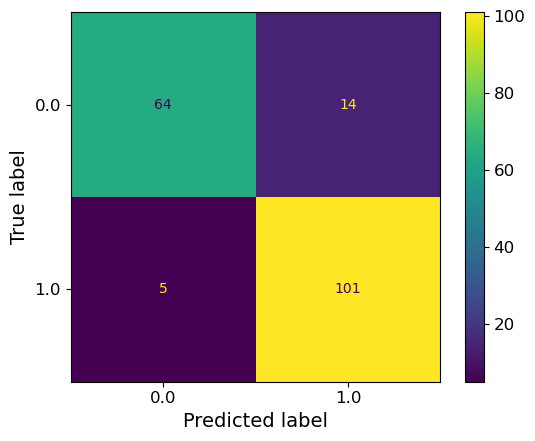

Saving figure RandomForest confusion matrix All features (Final Model)


<Figure size 640x480 with 0 Axes>

In [84]:
cm = confusion_matrix(y_test, preds_rfc, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rfc.classes_)

disp.plot()
plt.show()
save_fig('RandomForest confusion matrix All features (Final Model)')

## ROC Plot

In [85]:
rfc_probs = rfc_final.predict_proba(X_test)
rfc_probs = rfc_probs[:,1]

In [86]:
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, rfc_probs)

In [87]:
def plot_roc_curve(tpr, fpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal line
    plt.title('Receiver Operating Characteristic', fontsize=12)
    plt.axis([-0.015, 1.0, 0, 1.02])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.grid(True)

Saving figure roc_curve_comparison_plot


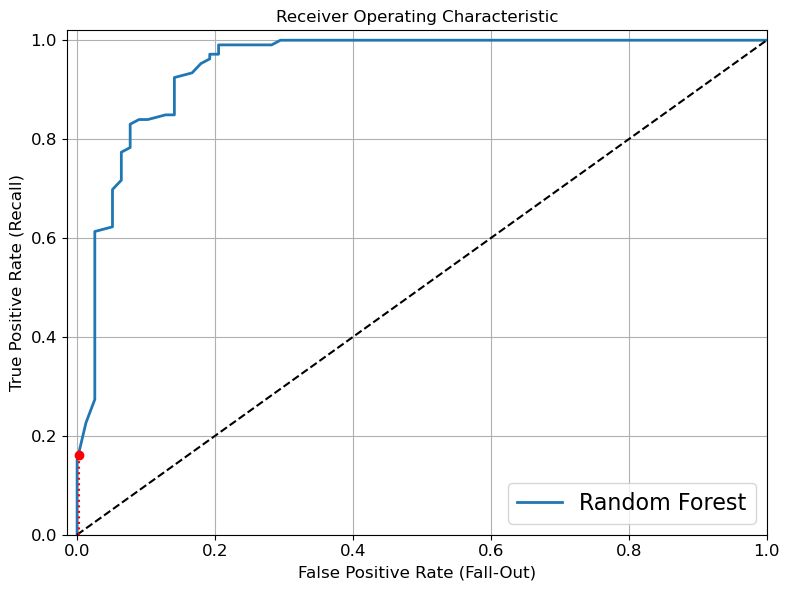

In [88]:
plt.figure(figsize=(8, 6))
#plt.plot(fpr_gbc, tpr_gbc, "b:", linewidth=2, label="GradientBoosting")
plot_roc_curve(tpr_rfc, fpr_rfc, "Random Forest")
plt.plot([.002, .002], [0., 0.162], "r:")      # dashed red line
plt.plot([.002], [0.162], "ro")                # red circle
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

# Final Models Performance Summary
- The fineal model generalizes well with the  test set, delivering similar results as with the validation set
- Lets loot at this model with a ROC plot.

In [89]:
Models_final = pd.DataFrame({'Model': ['RandomForest'],'Accuracy':[round(acc_score_rfc*100,2)],
                             'Precision': [round(prec_score_rfc*100,2)],'Recall': [round(recall_score_rfc*100,2)],
                             'AUC': [round(auc_score_rfc*100,2)]})
Models_final = Models_final.rename('{}_final'.format)
Models_final

,Model,Accuracy,Precision,Recall,AUC
0_final,RandomForest,89.67,87.83,95.28,88.67


# Final Model:  Random Forest Classifier with All Features